>## Global Market forecasting with Facebook Prophet

---
### *Cleaning & Preparing Data*

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from sklearn.metrics import*
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
df = pd.read_excel("Dataset11.xlsx")
online = df.loc[df['SALES_CHANNEL'] == 'Online']
offline = df.loc[df['SALES_CHANNEL'] == 'Offline']

In [2]:
cols = ['REGION','SALES_CHANNEL','UNITS_SOLD','COUNTRY','ITEM_TYPE','QUALITY_PRODUCT','ORDER_DATE','ORDER_ID','UNIT_PRICE','UNIT_COST','TOTAL_COST']
online.drop(cols, axis=1, inplace=True)
offline.drop(cols, axis=1, inplace=True)

online = online.sort_values('SHIP_DATE')
offline = offline.sort_values('SHIP_DATE')

online = online.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()
offline = offline.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()

---
### *Data exploration*

In [3]:
online = online.set_index('SHIP_DATE')
offline = offline.set_index('SHIP_DATE')

y_online = online['TOTAL_PROFIT'].resample('MS').mean()
y_offline = offline['TOTAL_PROFIT'].resample('MS').mean()

online = pd.DataFrame({'SHIP_DATE':y_online.index, 'TOTAL_PROFIT':y_online.values})
offline = pd.DataFrame({'SHIP_DATE': y_offline.index, 'TOTAL_PROFIT': y_offline.values})

store = online.merge(offline, how='inner', on='SHIP_DATE')
store.rename(columns={'TOTAL_PROFIT_x': 'online_TP', 'TOTAL_PROFIT_y': 'offline_TP'}, inplace=True)
store.head()

,SHIP_DATE,online_TP,offline_TP
0,2010-01-01,151361.340000,589951.338333
1,2010-02-01,732704.212500,568745.743333
2,2010-03-01,541667.808462,496859.488000
3,2010-04-01,440911.431000,610470.077500
4,2010-05-01,508304.620000,485720.598571


### *Plotting graph of historical data*

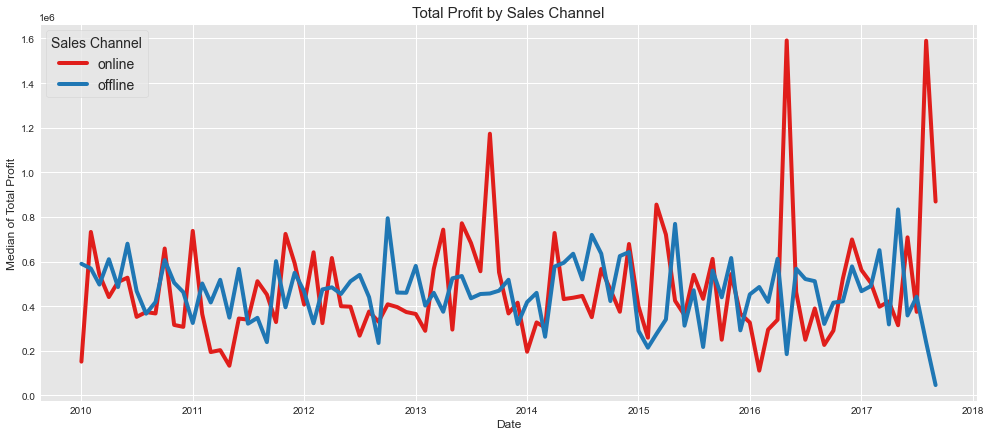

In [4]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Set1')
sns_c = sns.color_palette(palette='Set1')

fig, ax = plt.subplots(figsize=(15, 6.5))

ax = sns.lineplot(x=store['SHIP_DATE'], y=store['online_TP'], color='#E01E1B', label='online');
ax = sns.lineplot(x=store['SHIP_DATE'], y=store['offline_TP'], color='#1f77b4', label='offline');

ax.legend(loc='upper left',title = 'Sales Channel')
ax.set_title('Total Profit by Sales Channel', fontsize = 15)
ax.set(ylabel='Median of Total Profit',xlabel='Date')
plt.savefig('2.svg');

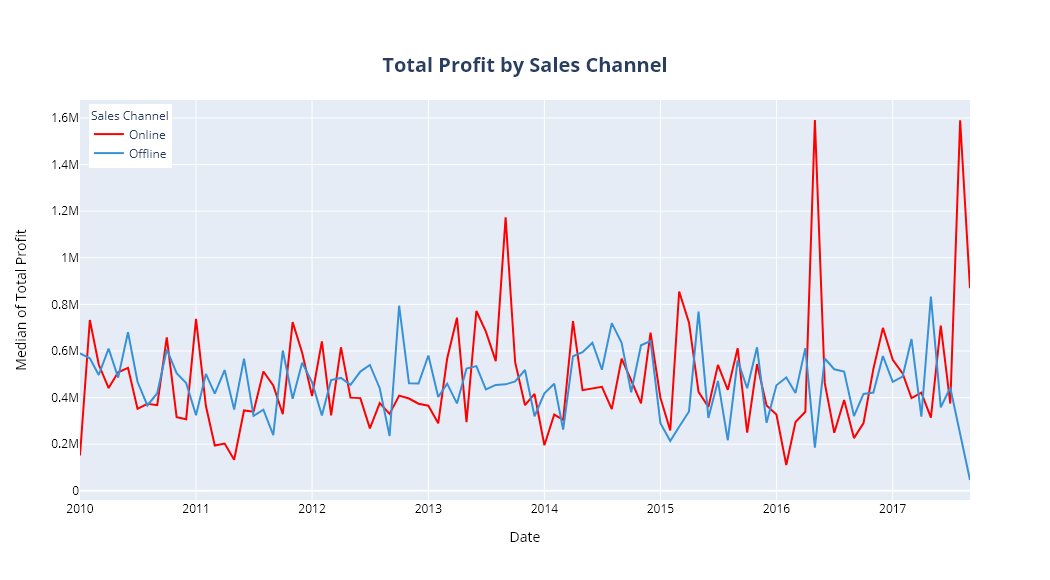

In [5]:
import plotly.graph_objects as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=store['SHIP_DATE'], 
    y=store['online_TP'],
    line=dict(color='red'),
#     stackgroup='one',
    mode='lines',
    name='Online'
))

fig.add_trace(go.Scatter(
    x=store['SHIP_DATE'], 
    y=store['offline_TP'],
    line=dict(color='#3791D7'),
#     stackgroup='one',
    mode='lines',
    name='Offline'
))

fig.update_layout(
    legend_title_text='Sales Channel',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
    yaxis=dict(title="Median of Total Profit",color='black'),
    xaxis=dict(title="Date",color='black'),
    title={
        'font_size':20,
        'text': "<b>Total Profit by Sales Channel<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
img_bytes = fig.to_image(format="png", width=1050, height=580, validate=True)
Image(img_bytes)

---
## Introduction to Prophet — the main concepts
### *Prophet Forecasting Model*
Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

### *Equation of the model is -*

<p align="center">
  <img src="https://miro.medium.com/max/659/1*Oe2mGHiiwDMmRcBlbvS39Q.png?raw=true" alt="Sublime's custom image"/>
</p>

**where:**
- $g(t)$ : the trend function which models non-periodic changes using either a non linear saturation growth model or piecewise linear regression model.

- $s(t)$ : the seasonal functional (yearly, weekly and daily) which models the periodic changes in the value of the time series. This component is modelled using a Fourier transform and if you want you can add your own seasonalities.

- $h(t)$ : represents the function for modelling holidays and special impact events. You can add your own set of custom holidays and special events.

- $ε(t)$ : the models error/noise which is assumed being normal distributed

**In other words, the procedure’s equation can be written**

<p align="center">
  <img src="https://miro.medium.com/max/399/1*ou96ceGd-wtOMFXSUl0Dtw.png?raw=true" alt="Sublime's custom image"/>
</p>

In [6]:
from fbprophet import Prophet
import logging

# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

In [172]:
online = online.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
online_model = Prophet(changepoint_prior_scale=0.01, interval_width=0.95,yearly_seasonality=True)
online_model.fit(online)

offline = offline.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
offline_model = Prophet(changepoint_prior_scale=0.01, interval_width=0.95,yearly_seasonality=True)
offline_model.fit(offline)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
online_forecast = online_model.make_future_dataframe(periods=12*3, freq='MS')
online_forecast = online_model.predict(online_forecast)

offline_forecast = offline_model.make_future_dataframe(periods=12*3, freq='MS')
offline_forecast = offline_model.predict(offline_forecast)

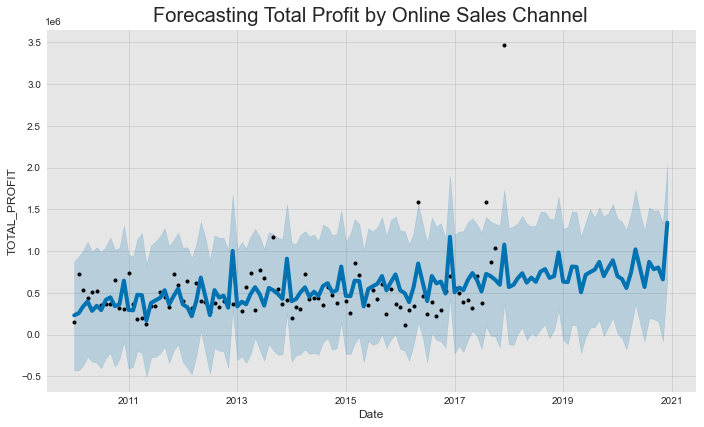

In [174]:
online_model.plot(online_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')
plt.title('Forecasting Total Profit by Online Sales Channel');

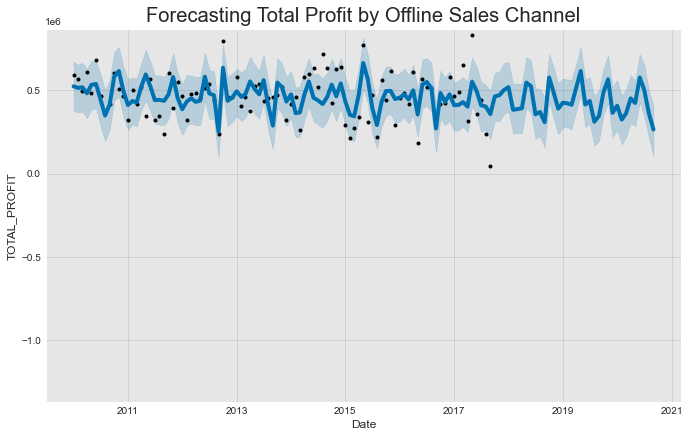

In [129]:
offline_model.plot(offline_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')
plt.title('Forecasting Total Profit by Offline Sales Channel');

---
### *Compare Forecasts*

In [175]:
online_names = ['online_%s' % column for column in online_forecast.columns]
offline_names = ['offline_%s' % column for column in offline_forecast.columns]

merge_online_forecast = online_forecast.copy()
merge_offline_forecast = offline_forecast.copy()

merge_online_forecast.columns = online_names
merge_offline_forecast.columns = offline_names

forecast = pd.merge(merge_online_forecast, merge_offline_forecast, how = 'inner', left_on = 'online_ds', right_on = 'offline_ds')

forecast = forecast.rename(columns={'online_ds': 'Date'}).drop('offline_ds', axis=1)
forecast.head()

,Date,online_trend,online_yhat_lower,online_yhat_upper,online_trend_lower,online_trend_upper,online_additive_terms,online_additive_terms_lower,online_additive_terms_upper,online_yearly,...,offline_additive_terms,offline_additive_terms_lower,offline_additive_terms_upper,offline_yearly,offline_yearly_lower,offline_yearly_upper,offline_multiplicative_terms,offline_multiplicative_terms_lower,offline_multiplicative_terms_upper,offline_yhat
0,2010-01-01,353868.709267,-427333.381161,8.787143e+05,353868.709267,353868.709267,-121157.472791,-121157.472791,-121157.472791,-121157.472791,...,-20588.689705,-20588.689705,-20588.689705,-20588.689705,-20588.689705,-20588.689705,0.0,0.0,0.0,478398.415461
1,2010-02-01,357455.758396,-426421.152044,9.395880e+05,357455.758396,357455.758396,-98522.966471,-98522.966471,-98522.966471,-98522.966471,...,-46916.816234,-46916.816234,-46916.816234,-46916.816234,-46916.816234,-46916.816234,0.0,0.0,0.0,451563.446851
2,2010-03-01,360695.673738,-369052.421373,1.005457e+06,360695.673738,360695.673738,-23740.853976,-23740.853976,-23740.853976,-23740.853976,...,-58331.341138,-58331.341138,-58331.341138,-58331.341138,-58331.341138,-58331.341138,0.0,0.0,0.0,439691.129100
3,2010-04-01,364282.722867,-261681.560483,1.115687e+06,364282.722867,364282.722867,34580.756857,34580.756857,34580.756857,34580.756857,...,3810.518744,3810.518744,3810.518744,3810.518744,3810.518744,3810.518744,0.0,0.0,0.0,501326.146901
4,2010-05-01,367754.060733,-320322.830049,9.927844e+05,367754.060733,367754.060733,-81887.131932,-81887.131932,-81887.131932,-81887.131932,...,80794.644351,80794.644351,80794.644351,80794.644351,80794.644351,80794.644351,0.0,0.0,0.0,577819.780179


---
### *Evaluating the performance of the Prophet ML algorithm*

In [57]:
import sklearn.metrics as metrics
mae = mean_absolute_error(forecast.online_trend, forecast.online_yhat)
mse = mean_squared_error(forecast.online_trend, forecast.online_yhat)
rmse = np.sqrt(mse)
r2 = r2_score(forecast.online_trend, forecast.online_yhat)

print("Evaluating the performance of Prophet ML algorithm:")
print("Mean Absolute Error:",mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R Square:", r2)

Evaluating the performance of Prophet ML algorithm:
Mean Absolute Error: 0.13253760602473286
Mean Squared Error: 0.39244025167670094
Root Mean Squared Error: 0.6264505181390634
R Square: 0.9582625835864


In [59]:
scores=pd.DataFrame({'Model':['Prophet'],
                    'Mean Squared Error':[mse.mean()],
                    'Mean Absolute Error':[mae.mean()],
                     'Root Mean Squared Error':[np.mean(rmse)],
                     'R Square':[r2.mean()]})

scores

,Model,Mean Squared Error,Mean Absolute Error,Root Mean Squared Error,R Square
0,Prophet,0.39244,0.132538,0.626451,0.958263


---
### *Visualizing the Totil Profit forecast*

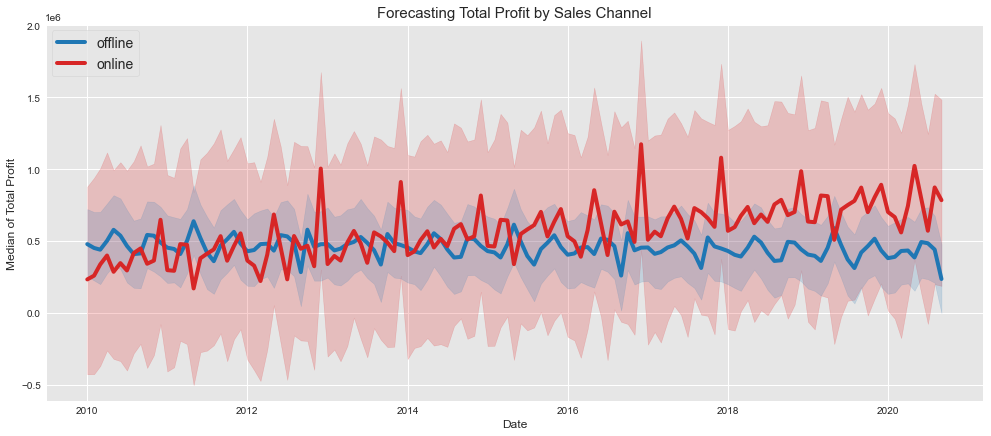

In [176]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Set1')
sns_c = sns.color_palette(palette='Set1')

fig, ax = plt.subplots(figsize=(15, 6.5))
sns.lineplot(x='Date', y='offline_yhat', color='#1f77b4', data=forecast, label='offline', ax=ax)

ax.fill_between(
    x=forecast['Date'],
    y1=forecast['online_yhat_lower'],
    y2=forecast['online_yhat_upper'],
    color=sns_c[0], 
    alpha=0.2
)
#D72626","#3791D7
sns.lineplot(x='Date', y='online_yhat', color='#D72626', data=forecast, label='online', ax=ax)
ax.fill_between(
    x=forecast['Date'],
    y1=forecast['offline_yhat_lower'],
    y2=forecast['offline_yhat_upper'],
    color=sns_c[1], 
    alpha=0.2
)
ax.legend(loc='upper left')
ax.set_title('Forecasting Total Profit by Sales Channel', fontsize = 15)
ax.set(ylabel='Median of Total Profit',xlabel='Date');
plt.savefig('1.svg')

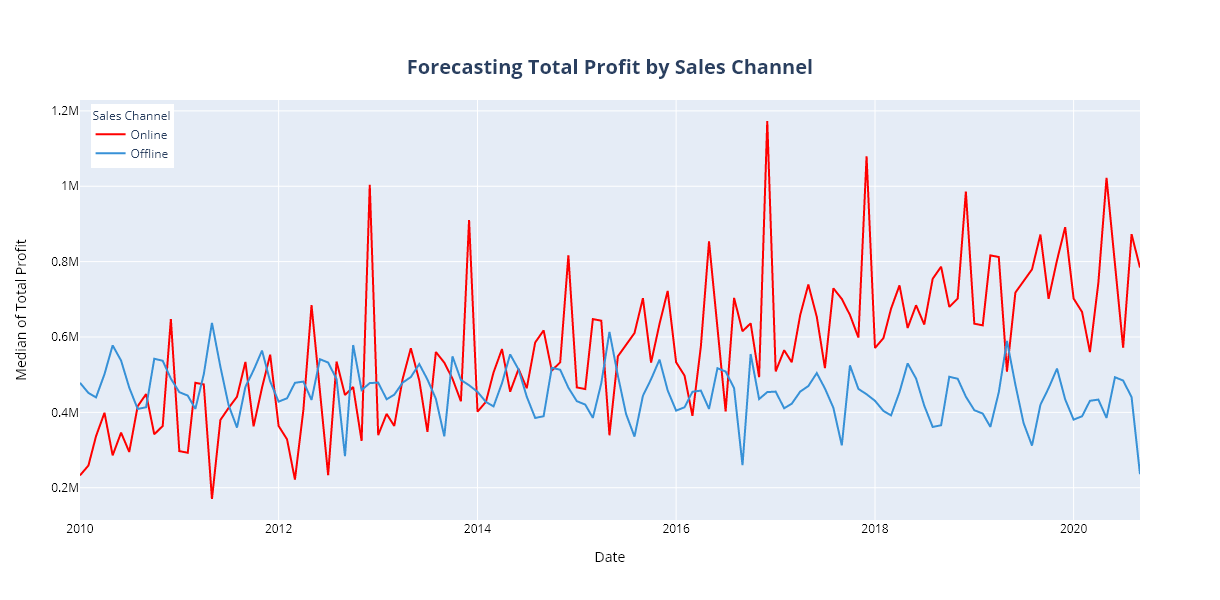

In [177]:
import plotly.graph_objects as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.online_yhat,
    line=dict(color='red'),
#     stackgroup='one',
    mode='lines',
    name='Online'
))

fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.offline_yhat,
    line=dict(color='#3791D7'),
#     stackgroup='one',
    mode='lines',
    name='Offline'
))

fig.update_layout(
    legend_title_text='Sales Channel',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
    yaxis=dict(title="Median of Total Profit",color='black'),
    xaxis=dict(title="Date",color='black'),
    title={
        'font_size':20,
        'text': "<b>Forecasting Total Profit by Sales Channel<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
img_bytes = fig.to_image(format="png", width=1220, height=600, validate=True)
Image(img_bytes)